In [7]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [8]:
df = pd.read_csv('train.csv/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
from tensorflow.keras.layers import TextVectorization
X = df['comment_text']
y = df[df.columns[2:]].values
MAX_FEATURES = 200000 # number of words in the vocabulary
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [5]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(60000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
print(len(dataset))
train = dataset.take(int(len(dataset)*.4))
val = dataset.skip(int(len(dataset)*.4)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.1))

9974


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [7]:
history = model.fit(train, epochs=6, validation_data=val)

Epoch 1/6
3989/3989 [==============================] - 5212s 1s/step - loss: 0.0711 - val_loss: 0.0514
Epoch 2/6
3989/3989 [==============================] - 12463s 3s/step - loss: 0.0486 - val_loss: 0.0436
Epoch 3/6
3989/3989 [==============================] - 26709s 7s/step - loss: 0.0436 - val_loss: 0.0444
Epoch 4/6
3989/3989 [==============================] - 6746s 2s/step - loss: 0.0399 - val_loss: 0.0413
Epoch 5/6
3989/3989 [==============================] - 13504s 3s/step - loss: 0.0367 - val_loss: 0.0391
Epoch 6/6
3989/3989 [==============================] - 8871s 2s/step - loss: 0.0332 - val_loss: 0.0386


<Figure size 800x500 with 0 Axes>

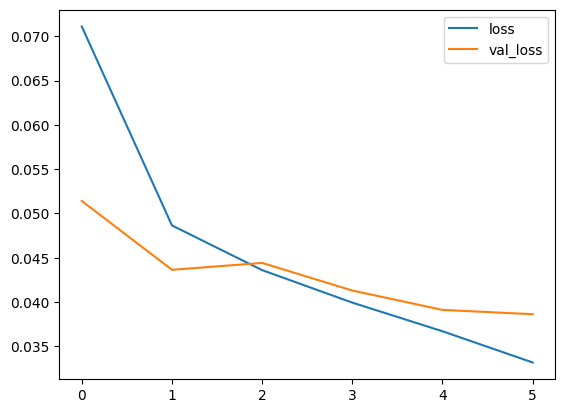

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [9]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [10]:
res = model.predict( np.array([input_text]))
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)
res.shape

1/1 [==============================] - 0s 140ms/step


(1, 6)

In [11]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 122ms/step
Precision: 0.8197368383407593, Recall:0.7310061454772949, Accuracy:0.48946839570999146


In [12]:
!pip install tensorflow tensorflow-gpu 
model.save('toxicity.h5')

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\KIIT\AppData\Local\Temp\pip-install-lw1gzbd5\tensorflow-gpu_f872973ad1144d778e8f537eb887aa7b\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build

In [12]:

import tensorflow as tf
model = tf.keras.models.load_model('toxicity.h5')


In [14]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [15]:
import gradio as gr
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\KIIT\AppData\Local\Temp\ipykernel_4856\3768202062.py:3: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
C:\Users\KIIT\AppData\Local\Temp\ipykernel_4856\3768202062.py:3: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
C:\Users\KIIT\AppData\Local\Temp\ipykernel_4856\3768202062.py:3: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),


In [16]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7862

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 1s 1s/step


In [17]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

1/1 [==============================] - 0s 98ms/step


In [26]:
import matplotlib.pyplot as plt # ploting package
%matplotlib inline
import seaborn as sns # For Visualization 
import warnings # Filtering warnings
warnings.filterwarnings('ignore')

#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count = df.iloc[:,2:].sum()

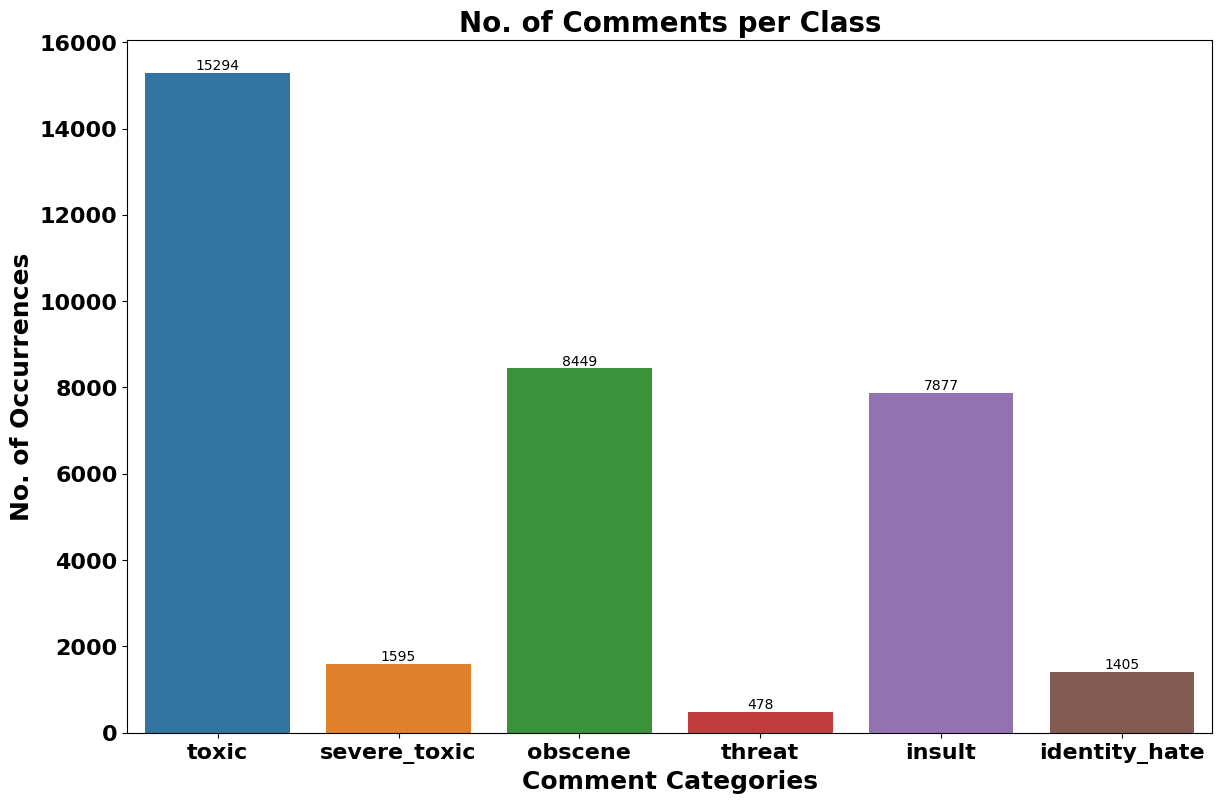

In [28]:
plt.figure(figsize=(14,9))

# Plot a bar chart using the index (category values) and the count of each category.
ax = sns.barplot(x=data_count.index,y=data_count.values)

plt.title("No. of Comments per Class", fontsize=20, fontweight='bold')
plt.ylabel('No. of Occurrences', fontsize=18,fontweight='bold')
plt.xlabel('Comment Categories', fontsize=18,fontweight='bold')
plt.xticks(fontsize=16,fontweight ='bold')
plt.yticks(fontsize=16,fontweight ='bold')
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [30]:
from wordcloud import WordCloud

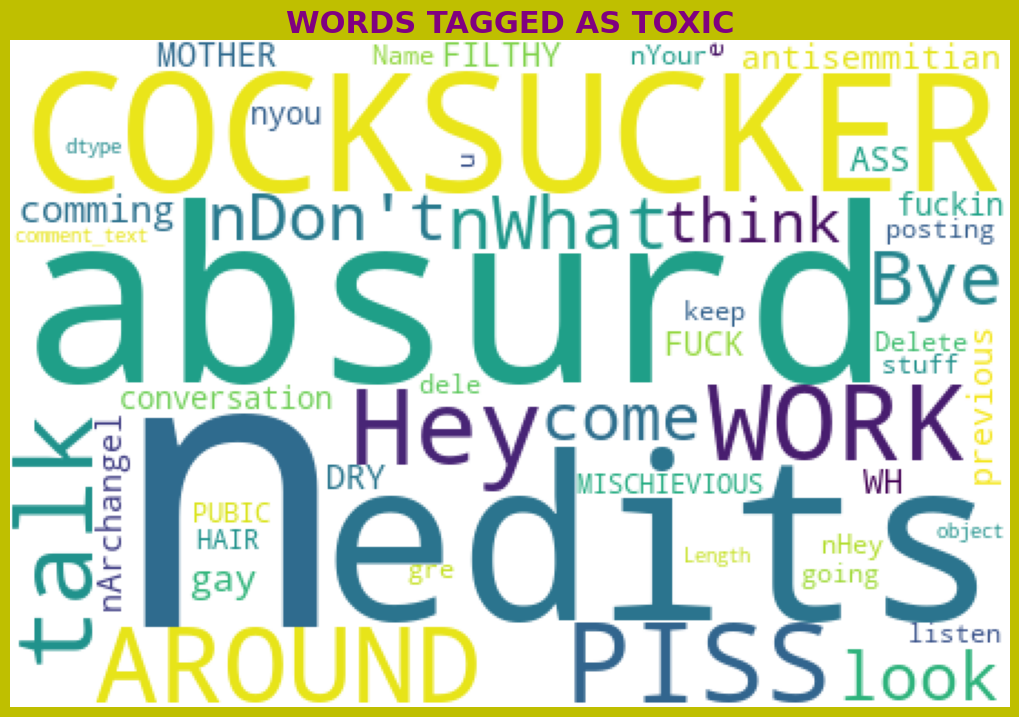

In [31]:
# Plotting for toxic
df_toxic=df[(df['toxic']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_toxic['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS TOXIC',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

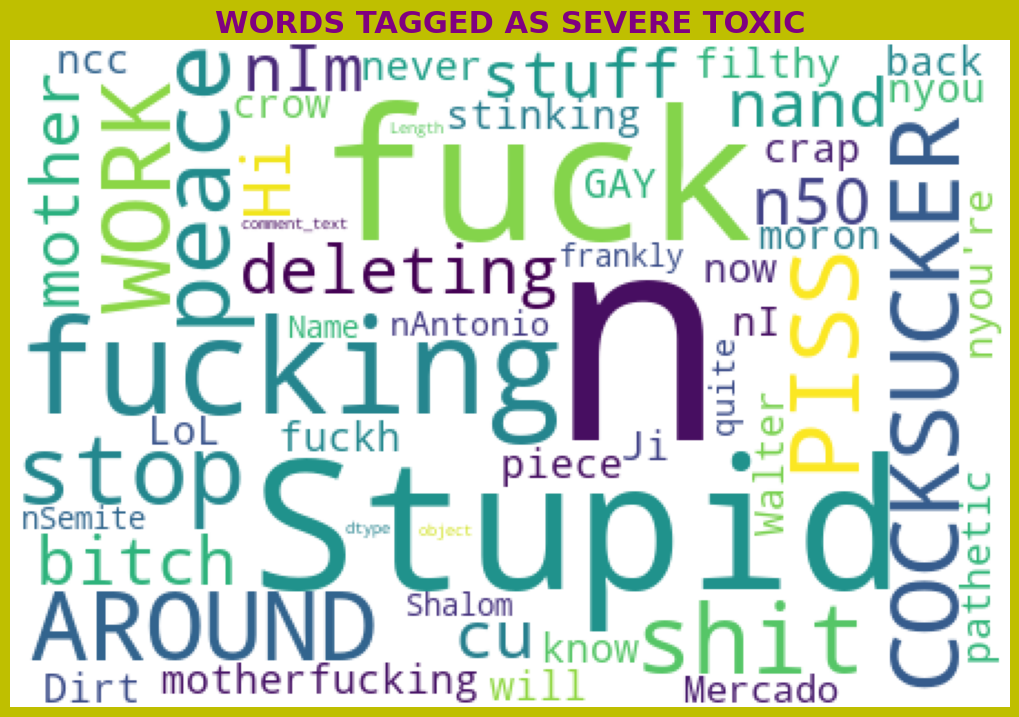

In [32]:
# Plotting for severe toxic
df_hdf_severetoxic=df[(df['severe_toxic']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_hdf_severetoxic['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS SEVERE TOXIC',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

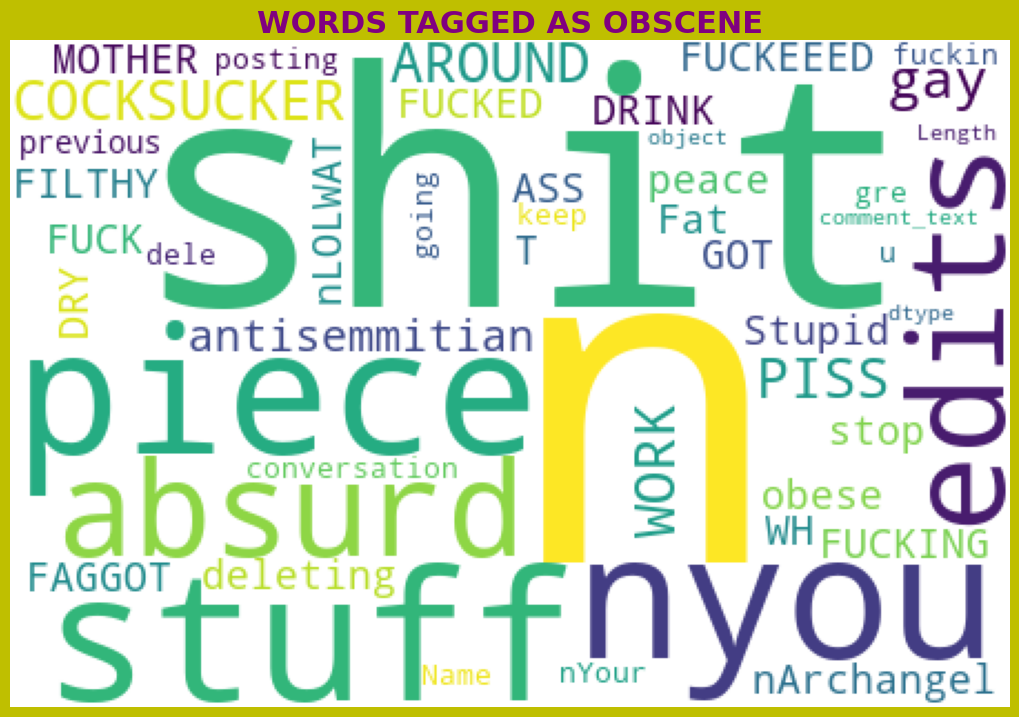

In [33]:
# Plotting for Obscene
df_obscene=df[(df['obscene']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_obscene['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS OBSCENE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

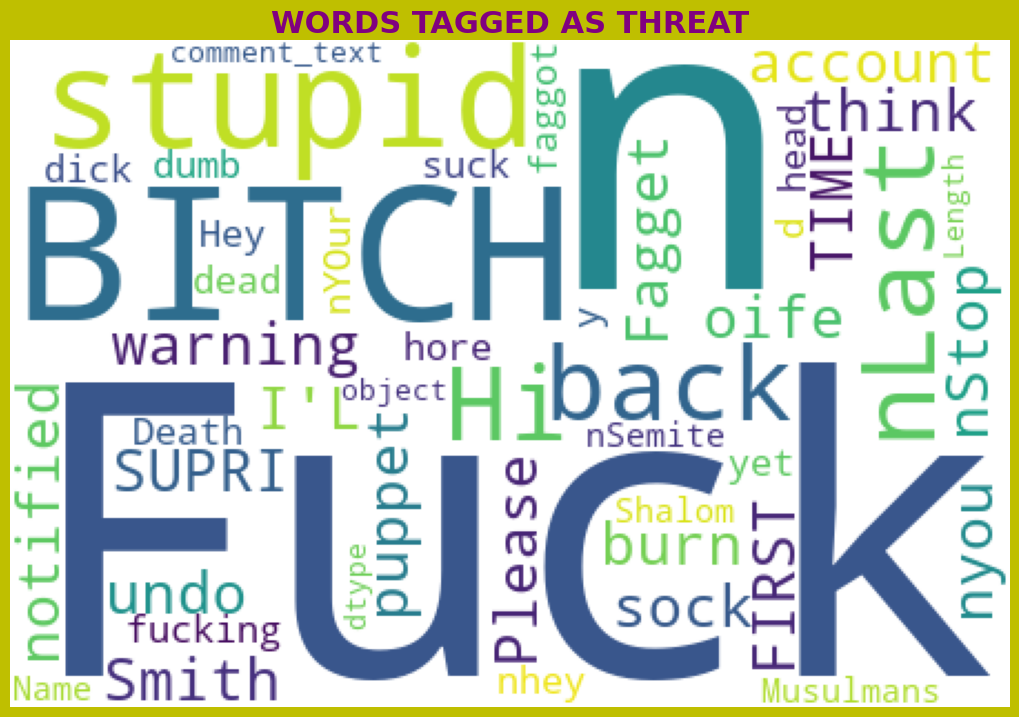

In [34]:
# Plotting for threat
df_threat=df[(df['threat']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_threat['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS THREAT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

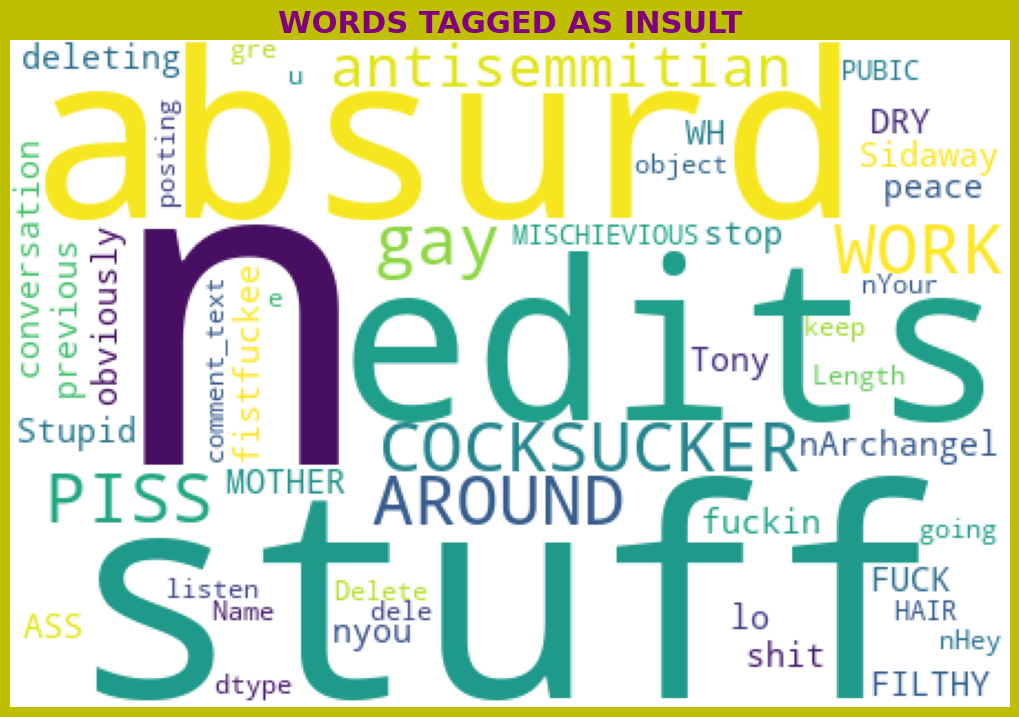

In [35]:
# Plotting for Insult
df_insult=df[(df['insult']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_insult['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS INSULT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

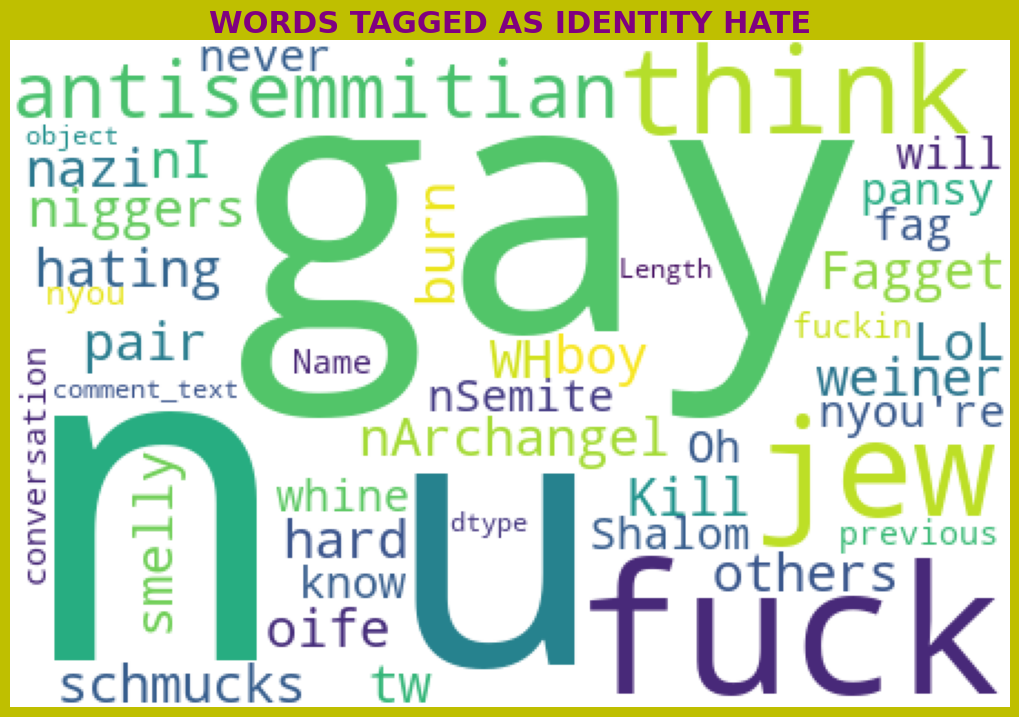

In [36]:
# Plotting for loathe
df_loathe=df[(df['identity_hate']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_loathe['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS IDENTITY HATE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()